# **00 - SetUp**

In [1]:
%pip install torchio --q
%pip install monai --q
%pip install celluloid --q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.9/52.9 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.0/194.0 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to

In [2]:
import os
import random
import numpy as np
import torch

def set_seed(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False  

set_seed(42)

In [3]:
from pathlib import Path

import numpy as np

import torchio as tio 
import torch
import pytorch_lightning as pl 

from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger 

# **01 - Preprocessing**

In [4]:
root_path = Path("/kaggle/input/medical-decathlon-lung-tumor-segmentation/Lung-Tumor-Segmentation/")

In [5]:
def get_img_path(patient_path: Path) -> Path:
    return next((patient_path / "data").glob("*.nii"))

def get_label_path(patient_path: Path) -> Path:
    return next((patient_path / "label").glob("*.nii"))

In [6]:
subject_path_list = list(root_path.glob("*"))

In [7]:
print(subject_path_list[0])
len(subject_path_list)

/kaggle/input/medical-decathlon-lung-tumor-segmentation/Lung-Tumor-Segmentation/7


63

In [8]:
subjects = []

for subject_path in subject_path_list:

    img_path = get_img_path(subject_path)
    label_path = get_label_path(subject_path)

    subject = tio.Subject(
        CT=tio.ScalarImage(img_path),  # lazy load
        Label=tio.LabelMap(label_path)     # lazy load
    )
    
    subjects.append(subject)

In [9]:
print(type(subjects[15]["CT"]), subjects[15]["CT"])
print(type(subjects[15]["Label"]), subjects[15]["Label"])

<class 'torchio.data.image.ScalarImage'> ScalarImage(shape: (1, 256, 256, 95); spacing: (1.00, 1.00, 1.00); orientation: RAS+; path: "/kaggle/input/medical-decathlon-lung-tumor-segmentation/Lung-Tumor-Segmentation/60/data/60_data.nii")
<class 'torchio.data.image.LabelMap'> LabelMap(shape: (1, 256, 256, 95); spacing: (1.00, 1.00, 1.00); orientation: RAS+; path: "/kaggle/input/medical-decathlon-lung-tumor-segmentation/Lung-Tumor-Segmentation/60/label/60_mask.nii")


In [10]:
label_data = subjects[0]['Label'].data.numpy()  # shape [1, H, W, D] or [H, W, D]

# unique values
unique_vals = np.unique(label_data)
print("Unique values:", unique_vals)

# count number of voxels per label
for val in unique_vals:
    count = np.sum(label_data == val)
    print(f"Label {val}: {count} voxels")

Unique values: [0. 1.]
Label 0.0: 5372936 voxels
Label 1.0: 1016 voxels


In [11]:
depths = [sub["CT"].shape[3] for sub in subjects]
heights = [sub["CT"].shape[1] for sub in subjects]
widths = [sub["CT"].shape[2] for sub in subjects]

median_depth = int(np.median(depths)) # use median cuz, mean is sensitive to outliers
print(median_depth)

222


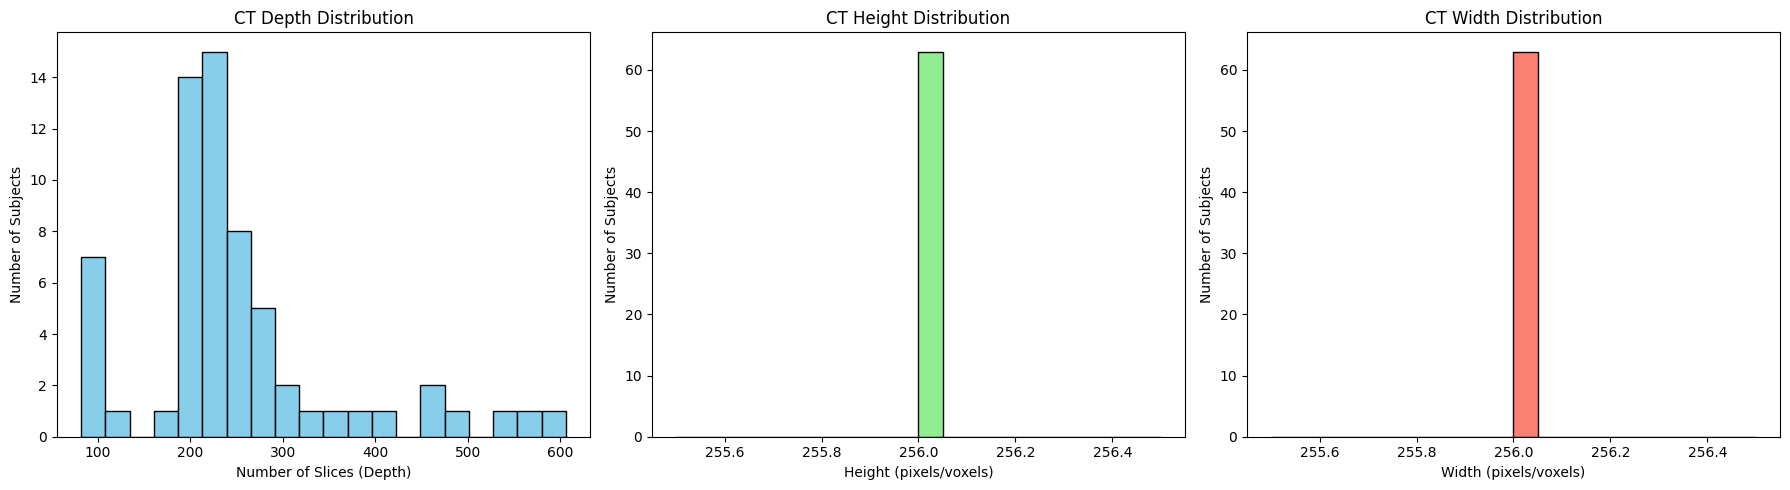

In [12]:
# Plot depth (dimensions)
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.hist(depths, bins=20, color='skyblue', edgecolor='black')
plt.title("CT Depth Distribution")
plt.xlabel("Number of Slices (Depth)")
plt.ylabel("Number of Subjects")

# Plot height
plt.subplot(1,3,2)
plt.hist(heights, bins=20, color='lightgreen', edgecolor='black')
plt.title("CT Height Distribution")
plt.xlabel("Height (pixels/voxels)")
plt.ylabel("Number of Subjects")

# Plot width
plt.subplot(1,3,3)
plt.hist(widths, bins=20, color='salmon', edgecolor='black')
plt.title("CT Width Distribution")
plt.xlabel("Width (pixels/voxels)")
plt.ylabel("Number of Subjects")

plt.tight_layout()
plt.show()

In [13]:
def crop_from_slice_30(tensor):
    return tensor[..., 30:]

In [14]:
process = tio.Compose([
    tio.ToCanonical(),
    tio.Resample(target='CT'),
    tio.Resample((1.5, 1.5, 1.5)),
    tio.RescaleIntensity((-1, 1)),
    tio.Lambda(crop_from_slice_30),  # keep from slice 30 onward
    tio.CropOrPad((256, 256, 200)),    
])

augmentation = tio.RandomAffine(scales=(0.9, 1.1), degrees=(-10, 10))

train_transform = tio.Compose([process, augmentation])
val_transform = tio.Compose([process])

In [15]:
train_dataset = tio.SubjectsDataset(subjects[:57], transform = train_transform) 
val_dataset = tio.SubjectsDataset(subjects[57:], transform = val_transform)  

In [16]:
train_sampler = tio.data.LabelSampler(
    patch_size=(96,96,96),
    label_name='Label',
    label_probabilities={0: 0.2, 1: 0.8}
)

val_sampler = tio.data.UniformSampler(patch_size=(96,96,96))

In [17]:
train_queue = tio.Queue(
    subjects_dataset=train_dataset,
    max_length=40,
    samples_per_volume=4,
    sampler=train_sampler,
    num_workers=2,
    shuffle_subjects=True,
    shuffle_patches=True
)

val_queue = tio.Queue(
    subjects_dataset=val_dataset,
    max_length=40,
    samples_per_volume=4,
    sampler=val_sampler,
    num_workers=2,
    shuffle_subjects=False,
    shuffle_patches=False
)

In [18]:
def subject_to_tensor(batch):
    
    ct_list = []
    label_list = []

    for subject in batch:                         # batch is a list of Subjects
        ct_list.append(subject['CT'].data)
        label_list.append(subject['Label'].data)

    return {                                      # Stack along a new batch dimension
        'CT': torch.stack(ct_list, dim=0),
        'Label': torch.stack(label_list, dim=0)
    }

In [19]:
train_loader = torch.utils.data.DataLoader(
    train_queue,  
    batch_size=2,            # So batch["CT"] for images: (2, 1, 64, 64, 64)
    num_workers=0,
    collate_fn=subject_to_tensor,
    shuffle = True
)

val_loader = torch.utils.data.DataLoader(
    val_queue, 
    batch_size=2,
    num_workers=0,
    collate_fn=subject_to_tensor
)

In [20]:
batch = next(iter(train_loader))
print(type(batch)) 

<class 'dict'>


# **02 - Model**

In [21]:
import torch.nn as nn
import torch.nn.functional as F

class AttentionGate3D(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        """
        F_g: number of channels in gating signal (from decoder)
        F_l: number of channels in skip connection (from encoder)
        F_int: number of intermediate channels (for dimensionality reduction)
        """
        super().__init__()
        self.W_g = nn.Sequential(
            nn.Conv3d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm3d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv3d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm3d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv3d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm3d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x, g):
        """
        x: encoder feature (skip connection)
        g: decoder feature (gating signal)
        """
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi  # elementwise attention mask

In [22]:
class ResidualBlock(nn.Module):
    def __init__(self, in_ch, out_ch, norm='instance'):
        super().__init__()
        self.conv1 = nn.Conv3d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv3d(out_ch, out_ch, 3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        if norm == 'instance':
            self.norm1 = nn.InstanceNorm3d(out_ch, affine=True)
            self.norm2 = nn.InstanceNorm3d(out_ch, affine=True)
        elif norm == 'group':
            self.norm1 = nn.GroupNorm(8, out_ch)
            self.norm2 = nn.GroupNorm(8, out_ch)

        # shortcut if channels differ
        if in_ch != out_ch:
            self.shortcut = nn.Conv3d(in_ch, out_ch, 1)
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        res = self.shortcut(x)
        out = self.conv1(x)
        out = self.norm1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.norm2(out)
        out += res
        out = self.relu(out)
        return out


class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=2):
        super().__init__()

        # Encoder
        self.layer1 = ResidualBlock(in_channels, 32)
        self.layer2 = ResidualBlock(32, 64)
        self.layer3 = ResidualBlock(64, 128)
        self.layer4 = ResidualBlock(128, 256)

        # Decoder
        self.upconv1 = nn.ConvTranspose3d(256, 128, kernel_size=2, stride=2)
        self.att1 = AttentionGate3D(F_g=128, F_l=128, F_int=64)
        self.layer5 = ResidualBlock(256, 128)

        self.upconv2 = nn.ConvTranspose3d(128, 64, kernel_size=2, stride=2)
        self.att2 = AttentionGate3D(F_g=64, F_l=64, F_int=32)
        self.layer6 = ResidualBlock(128, 64)

        self.upconv3 = nn.ConvTranspose3d(64, 32, kernel_size=2, stride=2)
        self.att3 = AttentionGate3D(F_g=32, F_l=32, F_int=16)
        self.layer7 = ResidualBlock(64, 32)

        self.layer8 = nn.Conv3d(32, out_channels, kernel_size=1)

        self.maxpool = nn.MaxPool3d(kernel_size=2, stride=2)

    def forward(self, x):
        # Encoder
        x1 = self.layer1(x)
        x2 = self.layer2(self.maxpool(x1))
        x3 = self.layer3(self.maxpool(x2))
        x4 = self.layer4(self.maxpool(x3))

        # Decoder
        d1 = self.upconv1(x4)
        x3_att = self.att1(x3, d1)
        d1 = torch.cat([d1, x3_att], dim=1)
        d1 = self.layer5(d1)

        d2 = self.upconv2(d1)
        x2_att = self.att2(x2, d2)
        d2 = torch.cat([d2, x2_att], dim=1)
        d2 = self.layer6(d2)

        d3 = self.upconv3(d2)
        x1_att = self.att3(x1, d3)
        d3 = torch.cat([d3, x1_att], dim=1)
        d3 = self.layer7(d3)

        out = self.layer8(d3)
        return out

In [23]:
from monai.losses import DiceCELoss

class LungTumorSegmentationModel(pl.LightningModule):
    
    def __init__(self, learning_rate=1e-4):
        super().__init__()

        self.save_hyperparameters()
        
        self.model = UNet(in_channels=1, out_channels=2)
        
        self.loss_fn = DiceCELoss(softmax=True, lambda_dice=0.7, lambda_ce=0.3)
    
    def forward(self, x):
        return self.model(x)
    
    def compute_loss(self, logits, mask):
        return self.loss_fn(logits, mask)
    
    def training_step(self, batch, batch_idx):
        images = batch['CT'].data         # (B, 1, H, W, D)
        labels = batch['Label'].data      # (B, 1, H, W, D)

        # Convert to one-hot for softmax activation
        labels = labels.squeeze(1).long()  # remove channel, ensure integer type
        labels_onehot = torch.nn.functional.one_hot(labels, num_classes=2)  # [B, D, H, W, 2]
        labels_onehot = labels_onehot.permute(0, 4, 1, 2, 3).float()        # -> [B, 2, D, H, W]
        
        logits = self(images)                    
        loss = self.compute_loss(logits, labels_onehot)
        
        self.log('train_loss', loss, on_epoch=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        images = batch['CT'].data         # (B, 1, H, W, D)
        labels = batch['Label'].data      # (B, 1, H, W, D)

        labels = labels.squeeze(1).long()  # remove channel, ensure integer type
        labels_onehot = torch.nn.functional.one_hot(labels, num_classes=2)  # [B, D, H, W, 2]
        labels_onehot = labels_onehot.permute(0, 4, 1, 2, 3).float()        # -> [B, 2, D, H, W]
        
        logits = self(images)                    
        loss = self.compute_loss(logits, labels_onehot)
        
        self.log('val_loss', loss, on_epoch=True)
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.hparams.learning_rate)

<frozen importlib._bootstrap_external>:1241: FutureWarning: The cuda.cudart module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.runtime module instead.
2025-10-25 07:11:23.162399: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761376283.531737      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761376283.646321      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [24]:
model = LungTumorSegmentationModel()

# **03 - Train**

In [25]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',        
    save_top_k=1,        
    mode='min',
    filename="best_model"
)

In [26]:
trainer = pl.Trainer(
    accelerator="auto",
    devices="auto",
    logger=TensorBoardLogger(save_dir="logs"),
    log_every_n_steps=10,
    callbacks=checkpoint_callback,
    max_epochs=30
)

| Parameter           | Where it’s used   | What it controls                   |
| ------------------- | ----------------- | ---------------------------------- |
| `every_n_epochs`    | `ModelCheckpoint` | Save checkpoint every N epochs     |
| `log_every_n_steps` | `Trainer`         | Log metrics every N training steps |

In [27]:
trainer.fit(model, train_loader, val_loader)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

# **04 - Evaluation**

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LungTumorSegmentationModel.load_from_checkpoint("/kaggle/input/checkpoints/LungTumor_CustomResNET.ckpt")
model.to(device);
model.freeze();
model.eval();

In [29]:
def segmentation_metrics(pred_mask, label):
    """
    TP,TN,FP,FN per batch
    """

    # ensure shape [B, H, W, D] -> [B, 1, H, W, D]
    if pred_mask.ndim == 4:
        pred_mask = pred_mask.unsqueeze(1)
    if label.ndim == 4:
        label = label.unsqueeze(1)
        
    pred_mask = pred_mask.bool()
    label = label.bool()
    
    # True positives, true negatives, false positives, false negatives # PER BATCH
    TP = (pred_mask & label).sum(dim=(1,2,3,4)).float()    
    TN = (~pred_mask & ~label).sum(dim=(1,2,3,4)).float()
    FP = (pred_mask & ~label).sum(dim=(1,2,3,4)).float()
    FN = (~pred_mask & label).sum(dim=(1,2,3,4)).float()

    # Metrics per batch item
    iou = TP / (TP + FP + FN + 1e-8) # epsilon to avoid division by 0
    sensitivity = TP / (TP + FN + 1e-8)
    specificity = TN / (TN + FP + 1e-8)

    # Mean over batch
    return iou.mean(), sensitivity.mean(), specificity.mean()


In [30]:
with torch.no_grad():
    
    all_ious, all_sens, all_spec = [], [], []

    for batch in val_loader:
        images = batch['CT'].data.to(device)
        labels = batch['Label'].data.to(device)  # shape [B, 1, H, W, D] or [B, H, W, D]
        labels = labels.squeeze(1)               # -> [B, H, W, D]
        
        logits = model(images)                   # [B, 2, H, W, D]
        probs = torch.softmax(logits, dim=1)     # normalize across the 2 channels
        preds = torch.argmax(probs, dim=1)       # -> [B, H, W, D] (0=bg, 1=tumor)
        
        # Convert to float mask if needed
        pred_mask = preds.float()
        label_mask = labels.float()

        iou, sens, spec = segmentation_metrics(pred_mask, label_mask)
        all_ious.append(iou.item())
        all_sens.append(sens.item())
        all_spec.append(spec.item())

mean_iou = sum(all_ious) / len(all_ious)
mean_sens = sum(all_sens) / len(all_sens)
mean_spec = sum(all_spec) / len(all_spec)

print(f"Mean IoU: {mean_iou:.4f}, Sensitivity: {mean_sens:.4f}, Specificity: {mean_spec:.4f}")

Mean IoU: 0.0207, Sensitivity: 0.0224, Specificity: 0.9997


In [31]:
n = 57

crop_or_pad = tio.CropOrPad((256, 256, 400))

scalarImg = crop_or_pad(subjects[n]["CT"])
scalarLab = crop_or_pad(subjects[n]["Label"])
img = scalarImg.data.squeeze(0)
label = scalarLab.data.squeeze(0)

In [32]:
from monai.inferers import sliding_window_inference

with torch.no_grad():
    # Apply patch-based inference to avoid OOM
    logits = sliding_window_inference(
        inputs=scalarImg.data.unsqueeze(0).to(device),  # [1, 1, H, W, D]
        roi_size=(128, 128, 128),  # size of sub-volumes; tweak based on GPU memory
        sw_batch_size=1,           # how many patches to process at once
        predictor=model,
        overlap=0.25,              # overlap ratio between patches (smooths seams)
    )

    probs = torch.softmax(logits, dim=1)        # [1, 2, H, W, D]
    pred_mask = torch.argmax(probs, dim=1).float()  # [1, H, W, D]

In [33]:
pred_mask = pred_mask.squeeze(0)
print("Pred mask shape:", pred_mask.shape)
print("Unique values in pred_mask:", torch.unique(pred_mask))

pred_mask = pred_mask.cpu()  # [H, W, D]

Pred mask shape: torch.Size([256, 256, 400])
Unique values in pred_mask: tensor([0., 1.], device='cuda:0')


In [34]:
img.shape

torch.Size([256, 256, 400])

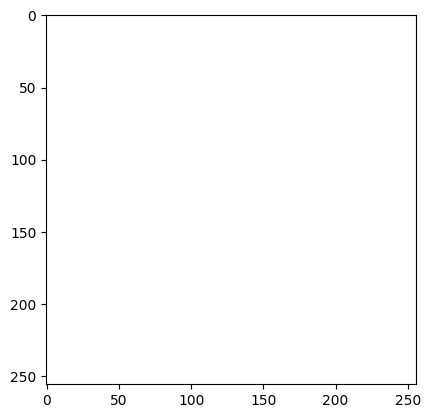

In [35]:
from celluloid import Camera
from IPython.display import HTML

fig = plt.figure()
camera = Camera(fig)

for i in range(img.shape[2]):
    plt.imshow(img[:, :, i], cmap="bone")

    # Ground truth mask (orange)
    gt_mask = np.ma.masked_where(label[:, :, i] == 0, label[:, :, i])
    plt.imshow(gt_mask, cmap="autumn", alpha=0.4)

    # Predicted mask (green)
    pred_mask_ = np.ma.masked_where(pred_mask[:, :, i] == 0, pred_mask[:, :, i])
    plt.imshow(pred_mask_, cmap="winter", alpha=0.4)

    camera.snap()

animation = camera.animate();
HTML(animation.to_html5_video())

This highlights:

🔴 Red = Ground Truth

🔵 Blue = Predicted Truth